In [90]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from matplotlib import axes
from scipy import stats
from IPython.display import clear_output
import xgboost as xgb
import statsmodels.stats.api as sms



def preprocess_y(y):
    y_normal = np.log(y)
    shift = y_normal.min()
    scale = y_normal.max() - shift
    y_norm = ((y_normal - shift) / scale - 0.5) * 2
    y_invf = lambda y: np.exp((y / 2. + 0.5) * scale + shift)
    return y_norm, y_invf

def preprocess_x(X):
#    X_norm = np.log(X + 1e-15)
#    X_norm = X / y[:, None, None]
#    mean = X_norm.mean()
#    std = X_norm.std()
#    X_norm = (X_norm - mean) / std
#    shift = X_norm.min()
#    scale = X_norm.max() - shift
#    X_norm = (X_norm - shift) / scale * 2 - 1
#    X_invf = lambda X: ((X + 1) * 2 * scale + shift) * std + mean
#    X_invf = lambda X, y: np.exp(X * std + mean)
#    X_invf = lambda X, y: (X * std + mean) * y
    X_norm = X
    X_invf = lambda X, y: X
    return X_norm, X_invf

def calculate_e_i(X):
    middle_pt = X.shape[1] // 2
    e_i = [np.zeros(X.shape[0])]
    for i in range(1, middle_pt):
        e_i.append(X[:, middle_pt-i:middle_pt+i, middle_pt-i:middle_pt+i].sum((1, 2)))
    e_i = np.asarray(e_i)
    e_i = e_i[1:] - e_i[:-1]
    e_i /= e_i[0]
    return e_i[1:]

X shape: (60000, 16, 16)
y shape: (60000,)


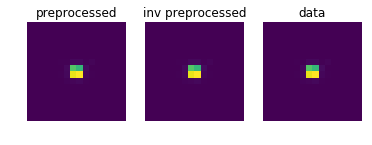

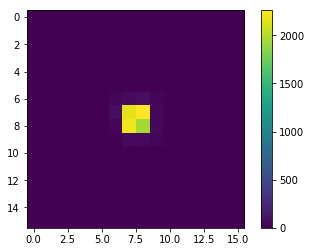

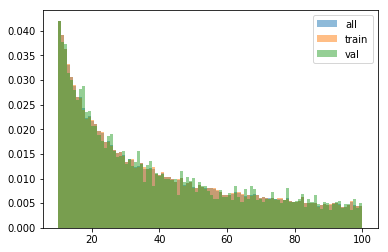

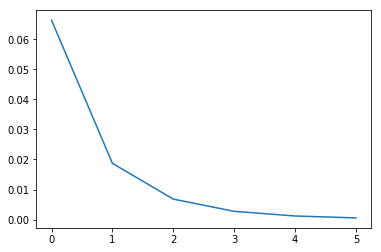

In [92]:
tmp = np.load('ecalNT_50K_e_10_100.npz')
X = np.pad(np.concatenate([np.load('EnergyDeposit.npy'), 
                           tmp['EnergyDeposit']], 0), 
           [(0, 0), (1, 1), (1, 1)],
           'constant',
           constant_values=0).astype('float32')[:, 8:24, 8:24]
y = np.concatenate([np.load('ParticleMomentum.npy'),
                    tmp['ParticleMomentum']], 0)[:, 2].astype('float32')
# check shape
print('X shape:', X.shape)
print('y shape:', y.shape)
y_norm = y
X_norm, X_invf = preprocess_x(X)
# check X
_, ax = plt.subplots(1, 3)
ax[0].imshow(X_norm[0])
ax[0].axis('off')
ax[0].set_title('preprocessed')
ax[1].imshow(X_invf(X_norm[0], y[0]))
ax[1].axis('off')
ax[1].set_title('inv preprocessed')
ax[2].imshow(X[0])
ax[2].axis('off')
ax[2].set_title('data')
plt.show()
plt.imshow(X_norm[1])
plt.colorbar()
plt.show()
# prepare for train
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X_norm = X_norm[shuffle]
y_norm = y_norm[shuffle]
train_frac = 0.9
N = X_norm.shape[0]
N_train = int(N * train_frac)
X_train = X_norm[:N_train]
X_val = X_norm[N_train:]
y_train = y_norm[:N_train]
y_val = y_norm[N_train:]
# check data distribution
plt.hist(y_norm, 100, normed=True, alpha=0.5)
plt.hist(y_train, 100, normed=True, alpha=0.5)
plt.hist(y_val, 100, normed=True, alpha=0.5)
plt.legend(['all', 'train', 'val'])
plt.show()
Ei = calculate_e_i(X)
plt.plot(Ei.mean(1))
plt.show()

In [93]:
import xgboost as xgb

In [94]:
dtrain = xgb.DMatrix(X_train[:, 6:10, 6:10].reshape(-1, 16), y_train)
dtest = xgb.DMatrix(X_val[:, 6:10, 6:10].reshape(-1, 16), y_val)

In [95]:
param = {'objective': 'reg:linear',
         'max_depth':  7,
         'min_child_weight': 10,
         'eta': 0.05,
#          'subsample': 0.8,
         'colsample': 0.8}
param['nthread'] = 8

In [96]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [97]:
num_round = 350
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-rmse:43.8441	train-rmse:43.7228
[1]	eval-rmse:41.6608	train-rmse:41.5436
[2]	eval-rmse:39.5873	train-rmse:39.473
[3]	eval-rmse:37.6156	train-rmse:37.5058
[4]	eval-rmse:35.7441	train-rmse:35.6367
[5]	eval-rmse:33.9637	train-rmse:33.8609
[6]	eval-rmse:32.2741	train-rmse:32.1737
[7]	eval-rmse:30.6689	train-rmse:30.5706
[8]	eval-rmse:29.1414	train-rmse:29.0476
[9]	eval-rmse:27.6894	train-rmse:27.6004
[10]	eval-rmse:26.3107	train-rmse:26.2254
[11]	eval-rmse:24.9998	train-rmse:24.9191
[12]	eval-rmse:23.7557	train-rmse:23.678
[13]	eval-rmse:22.5743	train-rmse:22.4988
[14]	eval-rmse:21.4508	train-rmse:21.3784
[15]	eval-rmse:20.3833	train-rmse:20.3139
[16]	eval-rmse:19.3695	train-rmse:19.3025
[17]	eval-rmse:18.4061	train-rmse:18.3417
[18]	eval-rmse:17.4907	train-rmse:17.4288
[19]	eval-rmse:16.6218	train-rmse:16.5615
[20]	eval-rmse:15.7956	train-rmse:15.7375
[21]	eval-rmse:15.0113	train-rmse:14.9546
[22]	eval-rmse:14.2657	train-rmse:14.2109
[23]	eval-rmse:13.5574	train-rmse:13.5043
[24]

[189]	eval-rmse:0.70972	train-rmse:0.555092
[190]	eval-rmse:0.709609	train-rmse:0.554883
[191]	eval-rmse:0.70966	train-rmse:0.554728
[192]	eval-rmse:0.709647	train-rmse:0.554628
[193]	eval-rmse:0.709581	train-rmse:0.554484
[194]	eval-rmse:0.70954	train-rmse:0.554315
[195]	eval-rmse:0.709494	train-rmse:0.554098
[196]	eval-rmse:0.709381	train-rmse:0.553916
[197]	eval-rmse:0.70937	train-rmse:0.553596
[198]	eval-rmse:0.709334	train-rmse:0.553478
[199]	eval-rmse:0.709292	train-rmse:0.55321
[200]	eval-rmse:0.709314	train-rmse:0.552854
[201]	eval-rmse:0.709289	train-rmse:0.552809
[202]	eval-rmse:0.709193	train-rmse:0.55264
[203]	eval-rmse:0.709142	train-rmse:0.552315
[204]	eval-rmse:0.70912	train-rmse:0.552175
[205]	eval-rmse:0.709079	train-rmse:0.551849
[206]	eval-rmse:0.709114	train-rmse:0.551668
[207]	eval-rmse:0.709157	train-rmse:0.551515
[208]	eval-rmse:0.709107	train-rmse:0.551295
[209]	eval-rmse:0.709088	train-rmse:0.55125
[210]	eval-rmse:0.709105	train-rmse:0.551095
[211]	eval-rmse:0.

In [98]:
bst.save_model('regression.model')